# Creating a workflow

This notebook showcases how to create a workflow using the [openEO Python client](https://github.com/Open-EO/openeo-python-client) within the Copernicus Data Space Ecosystem (CDSE). The workflow will be published as a [User Defined Process (UDP)](https://open-eo.github.io/openeo-python-client/udp.html#). UDPs allow you to encapsulate your processing workflow, which consists of multiple steps, into reusable openEO building blocks that can be called with a single command. This approach enables you to share and reuse your workflows across different projects and experiments.
 
In this example, we will create a workflow to generate a variability map. In a variability map, each image pixel is assigned a specific category, which represents the deviation of the pixel value from the mean pixel value. These maps can be used to implement precision agriculture practices by applying different fertilization strategies for each category. For instance, a farmer might choose to apply more product to areas of the field that exhibit a negative deviation and less to those with positive deviations (enhancing poorer areas), or concentrate the application on regions with positive deviations (focusing on the more productive areas of the field).

In [17]:
import rasterio
import matplotlib.pyplot as plt

def visualise_tif(path: str):
    with rasterio.open(path) as src:
        data = src.read(1)  # Read the first band
        plt.figure(figsize=(10, 10))
        plt.imshow(data, cmap='viridis')
        plt.colorbar()
        plt.show()

## Connection with CDSE openEO Federation

The first step, before creating any processing workflow in openEO, is to authenticate with an available openEO backend. In this example, we will use the CDSE openEO federation, which provides seamless access to both datasets and processing resources across multiple federated openEO backends.

In [2]:
import openeo

In [3]:
connection = openeo.connect(url="openeofed.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


## Defining the workflow parameters
The first step in creating an openEO workflow is specifying the [input parameters](https://open-eo.github.io/openeo-python-client/api.html#openeo.api.process.Parameter). These parameters enable users to execute the workflow with their own custom settings, making it adaptable to different datasets and use cases. openEO provides built-in [helper functions](https://open-eo.github.io/openeo-python-client/udp.html#process-parameters) that assist in defining these parameters correctly.

In [4]:
from openeo.api.process import Parameter

In [5]:
area_of_interest = Parameter.geojson(name='spatial_extent', description="Spatial extent for which to generate the variability map")
time_of_interest = Parameter.date(name='date', description="Date for which to generate the variability map")

## Implementation of the workflow
Next, we will begin implementing the variability map workflow. This involves using the predefined functions in openEO to create a straightforward workflow consisting of the following steps:
 
  1. Select the S2 data based on the `area_of_interest` and `time_of_interest` parameters.
  2. Calculate the NDVI for the S2 data.
  3. Apply an openEO User Defined Function (UDF) to calculate the deviation of each pixel against the mean pixel value of the datacube.

In [6]:
# Step 1. Select the S2 data based on the workflow parameters
s2_cube = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=area_of_interest,
    temporal_extent=[time_of_interest,time_of_interest],
)
    
s2_masked = s2_cube.mask_polygon(area_of_interest)

In [7]:
# Step 2. Calculate the S2 NDVI
s2_ndvi = s2_masked.ndvi()

In [8]:
# Step 3. Apply the UDF to calculate the variability map
calculate_udf = openeo.UDF.from_file("./files/variability_map.py")
varmap_dc = s2_ndvi.reduce_temporal(calculate_udf)

In [9]:
from IPython.display import JSON

JSON(varmap_dc.to_json())

/Users/bramjanssen/projects/earthcode/examples/.venv/lib/python3.13/site-packages/IPython/core/display.py:636: UserWarning: JSON expects JSONable dict or list, not JSON strings
  warnings.warn("JSON expects JSONable dict or list, not JSON strings")


<IPython.core.display.JSON object>

## Create an openEO-based workflow
In this next step, we will create our workflow by establishing our openEO User Defined Process (UDP). This action will create a public reference to the workflow we developed in the preceding steps. This can be achieved by using the [`save_user_defined_process`](https://open-eo.github.io/openeo-python-client/api.html#openeo.rest.connection.Connection.save_user_defined_process) function.

:::{note}
The publication of the UDP contains a public reference to the workflow, which can be shared with others. This allows users to execute the workflow without needing to recreate it from scratch, promoting collaboration and reuse of processing workflows.
:::

In [10]:
connection.save_user_defined_process(
    "variability_map",
    varmap_dc,
    parameters=[area_of_interest, time_of_interest],
    public=True
)

Preflight process graph validation raised: [UpstreamValidationInfo] Backend 'cdse' reported validation errors [ProcessParameterRequired] Process 'n/a' parameter 'spatial_extent' is required.


In the previous step, we created a workflow as a UDP in openEO. We can now use the public URL to share the workflow with others or to execute it in different contexts. The UDP encapsulates the entire processing logic, making it easy to apply the same workflow to different datasets or parameters without needing to redefine the steps each time. In this example, the published UDP is available at the following URL: [Variability Map UDP](https://openeo.dataspace.copernicus.eu/openeo/1.1/processes/u:6391851f-9042-4108-8b2a-3dd2e8a9dd0b/variability_map).

## Testing the workflow
After saving the workflow, we can test it by executing the UDP with specific parameters. This step allows us to verify that the workflow operates as expected and produces the desired results. We start by defining the parameters that we want to use for the test run. These parameters will be passed to the UDP when it is executed.

In [11]:
spatial_extent_value = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              5.170043941798298,
              51.25050990858725
            ],
            [
              5.171035037521989,
              51.24865722468999
            ],
            [
              5.178521828188366,
              51.24674578027137
            ],
            [
              5.179084341977159,
              51.24984764553983
            ],
            [
              5.170043941798298,
              51.25050990858725
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

date_value = "2025-05-01"

Next we use our previously created datacube `varmap_dc` to execute our workflow as an openEO batch job. This step involves submitting the job to the openEO backend, which will process the data according to the defined workflow and parameters. The backend will handle the execution of the workflow and return the results, which can then be analyzed or visualized as needed.



In [13]:
path =  "./files/varmap_workflow_test.tiff"

varmap_test = connection.datacube_from_process(
    "variability_map",
    spatial_extent=spatial_extent_value,
    date=date_value,
)
varmap_test.execute_batch(
    path,
    title="CDSE Federation - Variability Map Workflow Test", 
    description="This is an example of a workflow test containing the calculation of a variability map in Belgium",
)

Preflight process graph validation raised: [UpstreamValidationInfo] Backend 'cdse' reported validation errors [ProcessUnsupported] Process with identifier 'variability_map' is not available in namespace 'None'.


0:00:00 Job 'cdse-j-2508191413394aa3adfbb79fd944e8ce': send 'start'
0:00:13 Job 'cdse-j-2508191413394aa3adfbb79fd944e8ce': created (progress 0%)
0:00:19 Job 'cdse-j-2508191413394aa3adfbb79fd944e8ce': created (progress 0%)
0:00:26 Job 'cdse-j-2508191413394aa3adfbb79fd944e8ce': created (progress 0%)
0:00:34 Job 'cdse-j-2508191413394aa3adfbb79fd944e8ce': running (progress N/A)
0:00:44 Job 'cdse-j-2508191413394aa3adfbb79fd944e8ce': running (progress N/A)
0:00:57 Job 'cdse-j-2508191413394aa3adfbb79fd944e8ce': running (progress N/A)
0:01:13 Job 'cdse-j-2508191413394aa3adfbb79fd944e8ce': running (progress N/A)
0:01:32 Job 'cdse-j-2508191413394aa3adfbb79fd944e8ce': finished (progress 100%)


<BatchJob job_id='cdse-j-2508191413394aa3adfbb79fd944e8ce'>

Finally, we can visualize the results of our workflow. This step allows us to see the output of the variability map and assess its quality and relevance for our specific use case. Visualization is a crucial part of the workflow, as it helps in interpreting the results and making informed decisions based on the data processed by our openEO workflow.

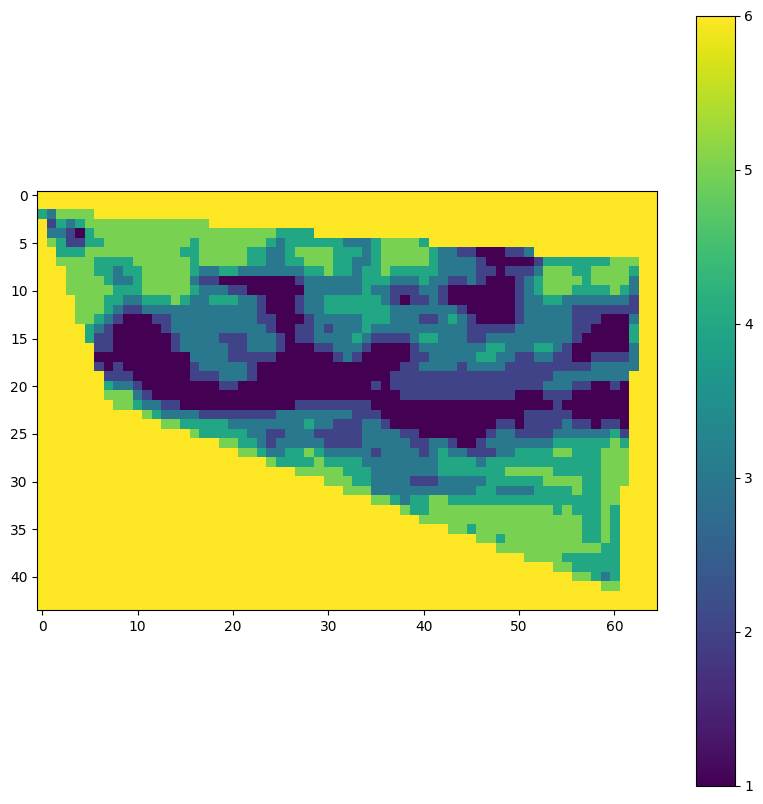

In [18]:
visualise_tif(path)